In [14]:
# Run this once per kernel
%load_ext autoreload
%autoreload 2
import re
import time
import pickle
import numpy as np
import sys
from edit_distance import SequenceMatcher
import torch
from dataset import SpeechDataset
import matplotlib.pyplot as plt
from neural_decoder.dataset import getDatasetLoaders
import neural_decoder.lm_utils as lmDecoderUtils
from neural_decoder.model import GRUDecoder
import pickle
import argparse
import matplotlib.pyplot as plt
from neural_decoder.dataset import getDatasetLoaders
import neural_decoder.lm_utils as lmDecoderUtils
from neural_decoder.lm_utils import build_llama_1B
from neural_decoder.model import GRUDecoder
from neural_decoder.bit import BiT_Phoneme
import pickle
import argparse
from lm_utils import _cer_and_wer
import json
import os
import copy
from torch.utils.data import ConcatDataset
from loss import memo_loss_from_logits, forward_ctc
from collections import deque

import wandb
import math

from tta_utils import convert_sentence, compute_lambda, clean_transcription, get_phonemes, get_data_file, reverse_dataset, get_dataloader, decode_sequence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
get_phonemes('cat')

(tensor([20,  2, 31, 40]), tensor([4]))

In [17]:
saveFolder_data = "/data/willett_data/paper_results_wer/"
saveFolder_transcripts = "/data/willett_data/model_transcriptions_comp/"

output_file = 'leia'
device = "cuda:2"

if output_file == 'obi':
    model_storage_path = '/data/willett_data/outputs/'
elif output_file == 'leia':
    model_storage_path = '/data/willett_data/leia_outputs/'
    

In [18]:
base_dir = "/home3/skaasyap/willett"

load_lm = True

# LM decoding hyperparameters
acoustic_scale = 0.8
blank_penalty = np.log(2)

run_for_llm = False

if run_for_llm:
    return_n_best = True
    rescore = False
    nbest = 100
    print("RUNNING IN LLM MODE")
else:
    return_n_best = False
    rescore = False
    nbest = 1
    print("RUNNING IN N-GRAM MODE")
    
if load_lm and 'ngramDecoder' not in globals():
        
    lmDir = base_dir +'/lm/languageModel'
    ngramDecoder = lmDecoderUtils.build_lm_decoder(
        lmDir,
        acoustic_scale=acoustic_scale, #1.2
        nbest=nbest,
        beam=18
    )
    print("loaded LM")
    
elif load_lm:
    print("Already loaded LM")
    

RUNNING IN N-GRAM MODE
Already loaded LM


In [31]:
models_to_run = ['neurips_transformer_time_masked_held_out_days_2', 
                 'neurips_transformer_time_masked_held_out_days_1',
                 'neurips_transformer_time_masked_held_out_days']

shared_output_file = 'recal_more_data'
val_save_file = 'recal_more_data'
seeds_list = [0]

if len(shared_output_file) > 0:
    write_mode = "a"
else:
    write_mode = "w"
    
evaluate_comp = True
use_lm = True

partition = "competition" 
blank_id = 0
num_classes = 41


# no tta
baseline_args = {
    'dropout': 0, 
    'input_dropout': 0, 
    'max_mask_pct': 0, 
    'num_masks': 0
}

# corp
corp_args = {
    'learning_rate': [1e-3, 1e-3, 1e-3], 
    'repeats': 64,
    'adaptation_steps': 1,
    'WN+BS': True,
    'white_noise': 0.2,
    'baseline_shift': 0.05,
    'dropout': 0.35, 
    'input_dropout': 0.2, 
    'l2_decay': 1e-5, 
    'max_mask_pct': 0.075, 
    'num_masks': 20, 
    'freeze_patch': True
}

tta_mode = 'corp'

if tta_mode == 'corp':
    updated_args = corp_args  
else:
    updated_args = baseline_args

skip_models = ["neurips_transformer_time_masked_held_out_days", 
               "neurips_transformer_time_masked_held_out_days_2"]
skip_seeds = [1,2,3]


In [29]:
def get_lm_outputs(tf_logits):
    
    # prepare logits for n-gram language model decoding 
    logits_np = tf_logits.detach().cpu().numpy()
    logits_np = np.concatenate([
        logits_np[:, :, 1:],   # classes 1 to C-1
        logits_np[:, :, 0:1]   # class 0, preserved in its own dimension
    ], axis=-1)
    
    logits_np = lmDecoderUtils.rearrange_speech_logits(logits_np, has_sil=True)
    
    # obtain sentence from n-gram language model 
    decoded = lmDecoderUtils.lm_decode(
        ngramDecoder, logits_np[0],
        blankPenalty=blank_penalty,
        returnNBest=return_n_best, rescore=rescore
    )

    decoded = clean_transcription(decoded)
    
    y_pseudo, y_len_pseudo = get_phonemes(decoded)
    
    return decoded, y_pseudo, y_len_pseudo


In [30]:
for mn, model_name_str in enumerate(models_to_run):
    
    if model_name_str in skip_models:
        continue
    
    day_cer_dict, total_wer_dict = {}, {}

    for seed in seeds_list:
        
        if seed in skip_seeds:
            continue
        
        print(f"Running model: {model_name_str}_seed_{seed}")
        
        day_cer_dict[seed], total_wer_dict[seed] = [], []

        modelPath = f"{model_storage_path}{model_name_str}_seed_{seed}"
        output_file = f"{shared_output_file}_seed_{seed}" if shared_output_file else f"{model_name_str}_seed_{seed}"

        with open(f"{modelPath}/args", "rb") as handle:
            args = pickle.load(handle)
            
        model = BiT_Phoneme(
            patch_size=args['patch_size'], dim=args['dim'], dim_head=args['dim_head'],
            nClasses=args['nClasses'], depth=args['depth'], heads=args['heads'],
            mlp_dim_ratio=args['mlp_dim_ratio'], dropout=updated_args['dropout'], input_dropout=updated_args['input_dropout'],
            look_ahead=args['look_ahead'], gaussianSmoothWidth=args['gaussianSmoothWidth'],
            T5_style_pos=args['T5_style_pos'], max_mask_pct=updated_args['max_mask_pct'],
            num_masks=updated_args['num_masks'], mask_token_zeros=args['mask_token_zero'], max_mask_channels=0,
            num_masks_channels=0, dist_dict_path=None
        ).to(device)

        data_file = get_data_file(args['datasetPath'])

        trainLoader, testLoaders, loadedData = getDatasetLoaders(data_file, 64)
        args.setdefault('mask_token_zero', False)

        model.load_state_dict(torch.load(f"{modelPath}/modelWeights", map_location=device), strict=True)

        if tta_mode != 'baseline':
            print(updated_args['learning_rate'][mn])
            optimizer = torch.optim.AdamW(model.parameters(), lr=updated_args['learning_rate'][mn], 
                                          weight_decay=updated_args['l2_decay'],
                                            betas=(args['beta1'], args['beta2']))

            if updated_args['freeze_patch']:
                for name, p in model.named_parameters():
                    p.requires_grad = name in {
                        "to_patch_embedding.1.weight", "to_patch_embedding.1.bias",
                        "to_patch_embedding.2.weight", "to_patch_embedding.2.bias",
                        "to_patch_embedding.3.weight", "to_patch_embedding.3.bias"
                    }

        testDayIdxs = np.arange(5)
        valDayIdxs = [0, 1, 3, 4, 5] if mn == 2 else [0, 1, 2, 3, 4]

        model_outputs = {"logits": [], "logitLengths": [], "trueSeqs": [], "transcriptions": []}
        
        total_edit_distance = total_seq_length = 0
        nbest_outputs = []
        nbest_outputs_val = []
        
        for i, testDayIdx in enumerate(testDayIdxs):
            
            print("day ", i)
            
            ve = valDayIdxs[i]
        
            val_ds = reverse_dataset(SpeechDataset([loadedData['test'][ve]], return_transcript=True))
            test_ds = reverse_dataset(SpeechDataset([loadedData['competition'][i]], return_transcript=True))
            combined_ds = ConcatDataset([val_ds, test_ds])
            data_loader = get_dataloader(combined_ds)
            
            transcriptions_list = []
            decoded_list = []
            
            test_day_decoded_sents = []
            
            for trial_idx, (X, y, X_len, y_len, _, transcript) in enumerate(data_loader):
                            
                total_start = time.time()
                
                X, y, X_len, y_len = map(lambda x: x.to(device), [X, y, X_len, y_len])
                dayIdx = torch.tensor([ve], dtype=torch.int64).to(device)
                adjusted_len = model.compute_length(X_len)
                
                # obtain beam search + LM corrected outputs
                # do this before adaptation on that trial to make 
                # sure results are compatabile with a streaming system 
                model.eval()
                logits_eval = model(X, X_len, ve)
                decoded, y_pseudo, y_len_pseudo = get_lm_outputs(logits_eval)
                
                if tta_mode != 'baseline':
                
                    # generate multiple versions of the same input
                    if updated_args['repeats'] > 0:
                        
                        X = X.repeat(updated_args['repeats'], 1, 1)
                        y = y.repeat(updated_args['repeats'], 1)
                        y_len = y_len.repeat(updated_args['repeats'])
                        X_len = X_len.repeat(updated_args['repeats'])
                        adjusted_len = adjusted_len.repeat(updated_args['repeats'])
                        y_pseudo = y_pseudo.unsqueeze(0).repeat(updated_args['repeats'], 1).to(device) 
                        y_len_pseudo = y_len_pseudo.repeat(updated_args['repeats']).to(device)
                        
                    
                    # add white noise and baseline shift augmentations to each sample
                    if updated_args['WN+BS'] == True:
                        
                        X += torch.randn(X.shape, 
                                    device=device) * updated_args['white_noise']
                    
                        X += (
                            torch.randn([X.shape[0], 1, X.shape[2]], 
                            device=device)
                            * updated_args['baseline_shift']
                        )      
                    
                          
                    model.train()

                    for _ in range(updated_args['adaptation_steps']):
                
                        logits = model(X, X_len, ve)
                        
                        corp_loss = forward_ctc(logits, adjusted_len, y_pseudo, y_len_pseudo)
                        
                        optimizer.zero_grad()
                        corp_loss.backward()
                        optimizer.step()
    
                model.eval()
                
                # get validation performance 
                if trial_idx < len(val_ds):
     
                    decoded_list.append(decoded)
                    transcriptions_list.append(clean_transcription(transcript[0]))

                else:   
                    
                    test_day_decoded_sents.append(decoded)
                        
            _, wer = _cer_and_wer(decoded_list, transcriptions_list, outputType="speech", returnCI=False)
            print("DAY WER: ", wer)
            day_cer_dict[seed].append(wer)
            nbest_outputs.extend(test_day_decoded_sents[::-1]) # reverse each day back
            
        out_file = os.path.join(saveFolder_transcripts, output_file)
        with open(out_file + '.txt', write_mode, encoding="utf-8") as f:
            f.write("\n".join(nbest_outputs) + "\n")
        
        
    if val_save_file:
        print(f"SAVING VAL RESULTS FOR {model_name_str}")
        with open(f"{saveFolder_data}{model_name_str}_{val_save_file}.pkl", "wb") as f:
            pickle.dump(day_cer_dict, f)
            

Running model: neurips_transformer_time_masked_held_out_days_1_seed_0
day  0
DAY WER:  0.2281067556296914
day  1
DAY WER:  0.2571428571428571
day  2
DAY WER:  0.2921945239068247
day  3
DAY WER:  0.24347454000855798
day  4
DAY WER:  0.20142002989536623
SAVING VAL RESULTS FOR neurips_transformer_time_masked_held_out_days_1


In [93]:
#### 14 days training, 5 days testing results


# held out days 1 
day  0
DAY WER:  0.2281067556296914
day  1
DAY WER:  0.2571428571428571
day  2
DAY WER:  0.2921945239068247
day  3
DAY WER:  0.24347454000855798
day  4
DAY WER:  0.20142002989536623


torch.Size([64, 83, 41])

In [109]:
##### Highest training data condition #####

# No TTA results
day  0
DAY WER:  0.23643122676579925
day  1
DAY WER:  0.2644028996566196
day  2
DAY WER:  0.27292981804678795
day  3
DAY WER:  0.3243121335137573
day  4
DAY WER:  0.31900138696255204


# modified CORP
day  0
DAY WER:  0.21561338289962825
day  1
DAY WER:  0.22243418542541016
day  2
DAY WER:  0.21574452283698478
day  3
DAY WER:  0.2395128552097429
day  4
DAY WER:  0.22422561257512713


##### Medium training data condition #####

# No TTA results
day  0
DAY WER:  0.22477064220183487
day  1
DAY WER:  0.2594104308390023
day  2
DAY WER:  0.36125868410298323
day  3
DAY WER:  0.4338896020539153
day  4
DAY WER:  0.5392376681614349


# modified CORP 
day  0
DAY WER:  0.22768974145120935
day  1
DAY WER:  0.2494331065759637
day  2
DAY WER:  0.31426236207601144
day  3
DAY WER:  0.31664527171587503
day  4
DAY WER:  0.32772795216741407

##### Low training data condition #####

# no TTA
day  0
DAY WER:  0.41413276231263385
day  1
DAY WER:  0.508829568788501
day  2
DAY WER:  0.7594795539033458
day  3
DAY WER:  0.7954545454545454
day  4
DAY WER:  0.8411253620190319

# no TTA
day  0
DAY WER:  0.35460385438972164
day  1
DAY WER:  0.4369609856262834
day  2
DAY WER:  0.6159851301115241
day  3
DAY WER:  0.6416396103896104
day  4
DAY WER:  0.6466694249069094

# Modified CORP 
day  0
DAY WER:  0.33319057815845826
day  1
DAY WER:  0.39383983572895276
day  2
DAY WER:  0.5379182156133829
day  3
DAY WER:  0.5568181818181818
day  4
DAY WER:  0.54530

SyntaxError: invalid syntax (340173537.py, line 4)

In [ ]:
# without LM
day  0
DAY CER:  0.3284115035707392
day  1
DAY CER:  0.380046403712297
day  2
DAY CER:  0.5224416517055656
day  3
DAY CER:  0.5491719863077066
day  4
DAY CER:  0.5892558916311004

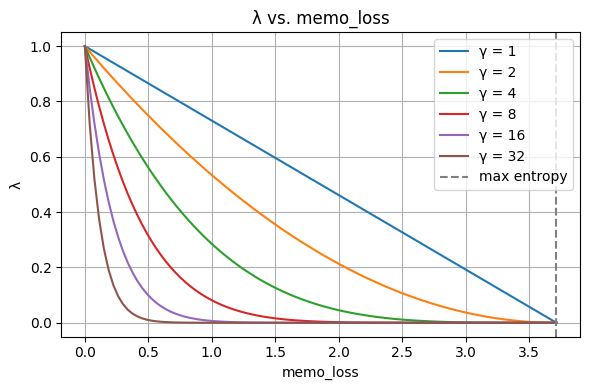

In [15]:
import torch
import math
import matplotlib.pyplot as plt

def compute_lambda(memo_loss, D, gamma):
    max_entropy = math.log(D)
    lambda_val = (1 - memo_loss / max_entropy).clamp(min=0.0, max=1.0)
    return lambda_val ** gamma

# Simulate range of memo losses
D = 41
memo_losses = torch.linspace(0, math.log(D), steps=100)
gammas = [1, 2, 4, 8, 16, 32]

plt.figure(figsize=(6, 4))
for g in gammas:
    lambdas = [compute_lambda(x, D, g) for x in memo_losses]
    plt.plot(memo_losses, lambdas, label=f"γ = {g}")

plt.axvline(math.log(D), color='gray', linestyle='--', label='max entropy')
plt.title("λ vs. memo_loss")
plt.xlabel("memo_loss")
plt.ylabel("λ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
math.log(41)

3.713572066704308

In [ ]:
#day_edit_distance = 0
#day_seq_length = 0
lambda_value_storage = []
loss_arr = []
for mn, model_name_str in enumerate(models_to_run):
    
    if model_name_str in skip_models:
        continue
    
    day_cer_dict, total_wer_dict = {}, {}

    for seed in seeds_list:
        
        if seed in skip_seeds:
            continue
        
        print(f"Running model: {model_name_str}_seed_{seed}")
        
        day_cer_dict[seed], total_wer_dict[seed] = [], []

        modelPath = f"{model_storage_path}{model_name_str}_seed_{seed}"
        output_file = f"{shared_output_file}_seed_{seed}" if shared_output_file else f"{model_name_str}_seed_{seed}"

        with open(f"{modelPath}/args", "rb") as handle:
            args = pickle.load(handle)
            
        model = BiT_Phoneme(
            patch_size=args['patch_size'], dim=args['dim'], dim_head=args['dim_head'],
            nClasses=args['nClasses'], depth=args['depth'], heads=args['heads'],
            mlp_dim_ratio=args['mlp_dim_ratio'], dropout=updated_args['dropout'], input_dropout=updated_args['input_dropout'],
            look_ahead=args['look_ahead'], gaussianSmoothWidth=args['gaussianSmoothWidth'],
            T5_style_pos=args['T5_style_pos'], max_mask_pct=updated_args['max_mask_pct'],
            num_masks=updated_args['num_masks'], mask_token_zeros=args['mask_token_zero'], max_mask_channels=0,
            num_masks_channels=0, dist_dict_path=None
        ).to(device)

        data_file = get_data_file(args['datasetPath'])

        trainLoader, testLoaders, loadedData = getDatasetLoaders(data_file, 64)
        args.setdefault('mask_token_zero', False)

        model.load_state_dict(torch.load(f"{modelPath}/modelWeights", map_location=device), strict=True)

        if tta_mode == 'cort' or tta_mode == 'corp' or tta_mode == 'combined':
            print(updated_args['learning_rate'][mn])
            optimizer = torch.optim.AdamW(model.parameters(), lr=updated_args['learning_rate'][mn], 
                                          weight_decay=updated_args['l2_decay'],
                                            betas=(args['beta1'], args['beta2']))

        for name, p in model.named_parameters():
            p.requires_grad = name in {
                "to_patch_embedding.1.weight", "to_patch_embedding.1.bias",
                "to_patch_embedding.2.weight", "to_patch_embedding.2.bias",
                "to_patch_embedding.3.weight", "to_patch_embedding.3.bias"
            }

        testDayIdxs = np.arange(5)
        valDayIdxs = [0, 1, 3, 4, 5] if mn == 2 else [0, 1, 2, 3, 4]

        model_outputs = {"logits": [], "logitLengths": [], "trueSeqs": [], "transcriptions": []}
        
        total_edit_distance = total_seq_length = 0
        nbest_outputs = []
        nbest_outputs_val = []
        
        
        for i, testDayIdx in enumerate(testDayIdxs):
            
            adapt_idx_arr = []
                        
            ve = valDayIdxs[i]
            
            val_ds = reverse_dataset(SpeechDataset([loadedData['test'][ve]], return_transcript=True))
            test_ds = reverse_dataset(SpeechDataset([loadedData['competition'][i]], return_transcript=True))
            combined_ds = ConcatDataset([val_ds, test_ds])
            data_loader = get_dataloader(combined_ds, batch_size=64)
            
            transcriptions_list = []
            decoded_list = []
            
            for batch_idx, (X_batch, y_batch, X_len_batch, y_len_batch, _, transcript_batch) in enumerate(data_loader):
                
                for trial_idx in range(batch_idx):
                    
                            
                total_start = time.time()
                
                X, y, X_len, y_len = map(lambda x: x.to(device), [X, y, X_len, y_len])
                
                # obtain LM corrected pseudo-label
                model.eval()
                logits_eval = model(X, X_len, ve, 0, 0, [0,0])
                decoded, y_pseudo, y_len_pseudo = get_lm_outputs(logits_eval)
                 
                if updated_args['WN+BS'] == True:
                    
                    X += torch.randn(X.shape, 
                                device=device) * updated_args['white_noise']
                
                    X += (
                        torch.randn([X.shape[0], 1, X.shape[2]], 
                        device=device)
                        * updated_args['baseline_shift']
                    )
                    
                
                 
                losses = []
                
                if tta_mode == 'corp':
                                    
                    model.train()
                    
                    for adapt_idx in range(updated_args['adaptation_steps']):
                        
                        X_batch     = torch.cat([t[0] for t in buffer_list],    dim=0)
                        y_batch     = torch.cat([t[1] for t in buffer_list],    dim=0)
                        X_len_batch = torch.cat([t[2] for t in buffer_list],    dim=0)
                        y_len_batch = torch.cat([t[3] for t in buffer_list],    dim=0)
                        
                        adjusted_len_batch = model.compute_length(X_len_batch)
                        
                        
                        logits = model(X_batch, X_len_batch, ve, 0, 0,
                                    [0,0])
                        
                        loss = forward_ctc(logits, adjusted_len_batch, y_batch, y_len_batch)
                        
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                        if trial_idx == 64:
                            sys.exit()                        
                        losses.append(loss.item())
                        
                          #if tta_mode == 'corp':
                        if np.mean(losses[-10:]) < updated_args['loss_threshold']:
                            break
                       

                model.eval()
                
                # get validation performance 
                if trial_idx < len(val_ds):
      
                    decoded_list.append(decoded)
                    transcriptions_list.append(clean_transcription(transcript[0]))
                   
            _, wer = _cer_and_wer(decoded_list, transcriptions_list, outputType="speech", returnCI=False)
            print("DAY WER: ", wer)
            day_cer_dict[seed].append(wer)
   
    if val_save_file:
        print(f"SAVING VAL RESULTS FOR {model_name_str}")
        with open(f"{saveFolder_data}{model_name_str}_{val_save_file}.pkl", "wb") as f:
            pickle.dump(day_cer_dict, f)
